In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.svm import OneClassSVM

In [5]:
# Load dataset
df = pd.read_csv("commodity-futures-trading-anomaly-detection.csv")

In [6]:
# Ensure date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
# Sort by date (important for time-series modeling)
df = df.sort_values(by='Date')

In [8]:
# Compute volatility as rolling standard deviation of Price Change over 10 days
df['Volatility_10d'] = df['Price_Change'].rolling(window=10).std()

In [9]:
# Drop NaN values (due to rolling window)
df = df.dropna()

In [10]:
df.shape

(362, 33)

In [11]:
# Select features
features = [
    "Market_participation",
    "Producer_merchant_processor_user_longs", "Producer_merchant_processor_user_shorts",
    "Swap_dealer_longs", "Swap_dealer_shorts", "Swap_dealer_spreads",
    "Money_manager_longs", "Money_manager_shorts", "Money_manager_spreads",
    "Other_reportable_longs", "Other_reportable_shorts", "Other_reportable_spreads",
    "Total_reportable_longs", "Total_reportable_shorts",
    "Non_reportable_longs", "Non_reportable_shorts",
    "GOLD", "Net_Producer_Pos", "Net_Swap_Dealer_Pos", "Net_Money_Manager_Pos", "Net_Other_Reportable_Pos",
    "SMA_10", "SMA_50", "Turning_Point", "Trader_Cluster", "Anomaly_Zscore"
]

In [12]:
X = df[features]
y = df["Volatility_10d"]

In [13]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
# Convert to sequences for LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i : i + seq_length])
        y_seq.append(y[i + seq_length])  # Predicting next volatility
    return np.array(X_seq), np.array(y_seq)

In [15]:
seq_length = 10  # Use past 10 days for prediction
X_seq, y_seq = create_sequences(X_scaled, y, seq_length)

In [16]:
print("X shape: ", X_seq.shape, "Y shape: ", y_seq.shape)

X shape:  (352, 10, 26) Y shape:  (352,)


In [17]:
# Split into train-test sets
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [18]:
print("X Train shape: ", X_train.shape, "X Test shape: ", X_test.shape, "Y Train shape: ", y_train.shape, "Y Test shape: ", y_test.shape)

X Train shape:  (281, 10, 26) X Test shape:  (71, 10, 26) Y Train shape:  (281,) Y Test shape:  (71,)


In [19]:
# Define LSTM model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
    LSTM(32, activation='relu', return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)  # Output: Volatility prediction
])

C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [21]:
# Train model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 2.2680e-04 - val_loss: 8.0163e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.6280e-05 - val_loss: 3.3632e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.9246e-05 - val_loss: 2.8361e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.2473e-05 - val_loss: 2.4660e-04
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.9905e-05 - val_loss: 2.2171e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.1049e-05 - val_loss: 2.1132e-04
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.7724e-05 - val_loss: 7.5379e-05
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.5724e-05 - val_loss: 7.9385e-05
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5554e-05 - val_loss: 5.6341e-05
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2356e-05 - val_loss: 4.5874e-05
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2031e-05 - val_loss: 3.7100e-

In [22]:
# Predict on test set
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step


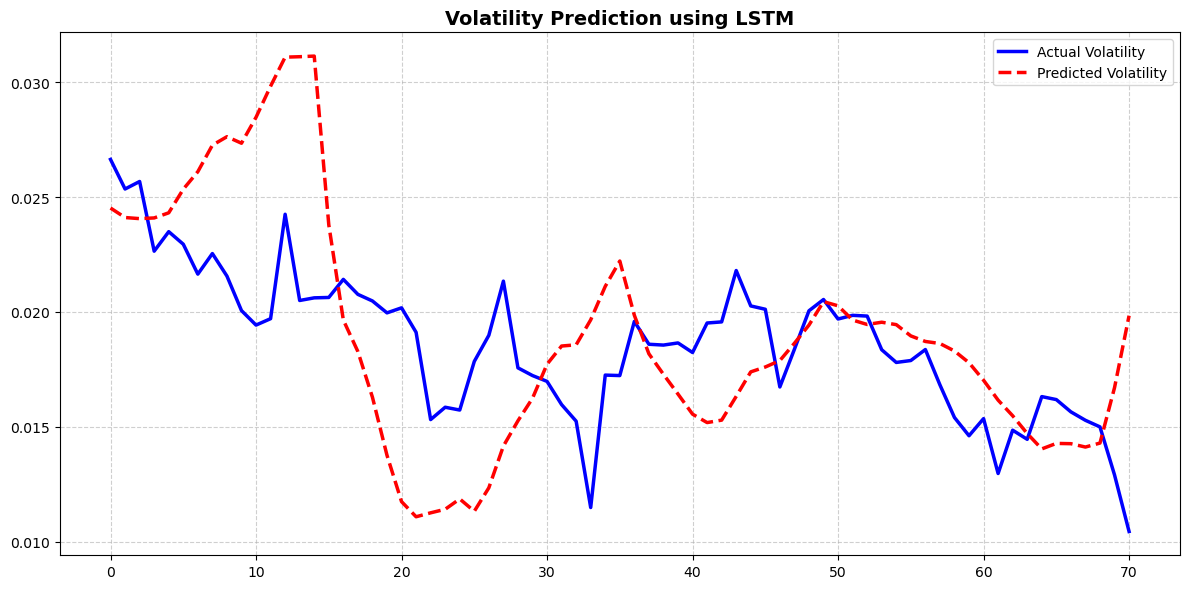

In [24]:
# Plot Actual vs Predicted Volatility
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Volatility", color='blue', linewidth=2.5)
plt.plot(y_pred, label="Predicted Volatility", color='red', linestyle='dashed', linewidth=2.5)
plt.legend()
plt.title("Volatility Prediction using LSTM", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)  # Add a subtle grid
plt.tight_layout() #avoid labels being cutoff
plt.savefig("Plots/Volatility Prediction using LSTM.png", dpi=200)
plt.show()

In [25]:
# Compute z-score of Price Change
df['Price_Change_Z'] = (df['Price_Change'] - df['Price_Change'].mean()) / df['Price_Change'].std()

In [26]:
# Define extreme events: Price Change beyond ±2 standard deviations
df['Extreme_Event'] = np.where(abs(df['Price_Change_Z']) > 2, 1, 0)

In [27]:
# Define thresholds (5% lowest and 5% highest price changes)
lower_threshold = df['Price_Change'].quantile(0.05)
upper_threshold = df['Price_Change'].quantile(0.95)

In [28]:
# Assign extreme event labels
df['Extreme_Event'] = np.where((df['Price_Change'] <= lower_threshold) | 
                               (df['Price_Change'] >= upper_threshold), 1, 0)

In [29]:
# Feature selection
features = [
    "Market_participation", "Producer_merchant_processor_user_longs", "Producer_merchant_processor_user_shorts",
    "Swap_dealer_longs", "Swap_dealer_shorts", "Swap_dealer_spreads",
    "Money_manager_longs", "Money_manager_shorts", "Money_manager_spreads",
    "Other_reportable_longs", "Other_reportable_shorts", "Other_reportable_spreads",
    "Net_Producer_Pos", "Net_Swap_Dealer_Pos", "Net_Money_Manager_Pos", "Net_Other_Reportable_Pos",
    "SMA_10", "SMA_50", "Turning_Point", "Anomaly_Zscore", "Anomaly_IsolationForest"
]

In [30]:
X = df[features]
y = df["Extreme_Event"]  # Binary classification target

In [31]:
print("X shape: ", X.shape, "Y shape: ", y.shape)

X shape:  (362, 21) Y shape:  (362,)


In [32]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
# Function to create time-series sequences
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i : i + seq_length])
        y_seq.append(y[i + seq_length])  # Predict next extreme event
    return np.array(X_seq), np.array(y_seq)

In [34]:
seq_length = 10  # Use past 10 days of data
X_seq, y_seq = create_sequences(X_scaled, y, seq_length)

In [35]:
print("Sequences: X shape: ", X_seq.shape, "Y shape: ", y_seq.shape)

Sequences: X shape:  (352, 10, 21) Y shape:  (352,)


In [36]:
# Split into train and test sets
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [37]:
print("X Train shape: ", X_train.shape, "X Test shape: ", X_test.shape, "Y Train shape: ", y_train.shape, "Y Test shape: ", y_test.shape)

X Train shape:  (281, 10, 21) X Test shape:  (71, 10, 21) Y Train shape:  (281,) Y Test shape:  (71,)


In [71]:
shapes = []

shapes.append({"Label":"X", "Shape": X.shape})
shapes.append({"Label":"Y", "Shape": X.shape})
shapes.append({"Label":"X Sequence", "Shape": X.shape})
shapes.append({"Label":"Y Sequence", "Shape": X.shape})
shapes.append({"Label":"X Train", "Shape": X_train.shape})
shapes.append({"Label":"X Test", "Shape": X_test.shape})
shapes.append({"Label":"Y Train", "Shape": y_train.shape})
shapes.append({"Label":"Y Test", "Shape": y_test.shape})

shapes_df = pd.DataFrame(shapes)

In [72]:
shapes_df

,Label,Shape
0,X,"(362, 21)"
1,Y,"(362, 21)"
2,X Sequence,"(362, 21)"
3,Y Sequence,"(362, 21)"
4,X Train,"(281, 10, 21)"
5,X Test,"(71, 10, 21)"
6,Y Train,"(281,)"
7,Y Test,"(71,)"


In [73]:
shapes_df.to_csv(r"Data/commodity-futures-trading-market-risk-exposure-shapes.csv")

In [38]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification output
])

C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
# Train model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.7838 - loss: 0.6532 - val_accuracy: 0.9577 - val_loss: 0.4586
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8715 - loss: 0.4767 - val_accuracy: 0.9577 - val_loss: 0.1773
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8885 - loss: 0.3548 - val_accuracy: 0.9577 - val_loss: 0.2171
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8611 - loss: 0.4055 - val_accuracy: 0.9577 - val_loss: 0.2612
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8604 - loss: 0.4183 - val_accuracy: 0.9577 - val_loss: 0.1910
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8550 - loss: 0.4303 - val_accuracy: 0.9577 - val_loss: 0.2072
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8479 - loss: 0.4440 - val_accuracy: 0.9577 - val_loss: 0.2346
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8508 - loss: 0.4243 - val_accuracy: 0.9577 - val_loss: 0.2150

In [41]:
# Predict on test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step


In [42]:
# Print classification report
classification_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

C:\Users\dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dell\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
classification_df.reset_index(inplace=True)

In [44]:
classification_df

,index,0,1,accuracy,macro avg,weighted avg
0,precision,0.957746,0.0,0.957746,0.478873,0.917278
1,recall,1.000000,0.0,0.957746,0.500000,0.957746
2,f1-score,0.978417,0.0,0.957746,0.489209,0.937076
3,support,68.000000,3.0,0.957746,71.000000,71.000000


In [70]:
classification_df.to_csv(r"Data/commodity-futures-trading-market-risk-exposure-classification-report.csv")

In [66]:
columns = []
for column in df.columns:
    columns.append({"Column": column, "Type": str(df[column].dtypes)})
columns_df = pd.DataFrame(columns)
columns_df

,Column,Type
0,Id,int64
1,Date,datetime64[ns]
2,Market_participation,float64
3,Producer_merchant_processor_user_longs,float64
4,Producer_merchant_processor_user_shorts,float64
5,Swap_dealer_longs,float64
6,Swap_dealer_shorts,float64
7,Swap_dealer_spreads,float64
8,Money_manager_longs,float64
9,Money_manager_shorts,float64


In [69]:
df.to_csv("Data/commodity-futures-trading-market-risk-exposure-df-columns.csv")

In [2]:
#df.to_csv(r"commodity-futures-trading-volatility-prediction.csv")

C:\Users\dell\AppData\Local\Temp\ipykernel_18564\2490574751.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


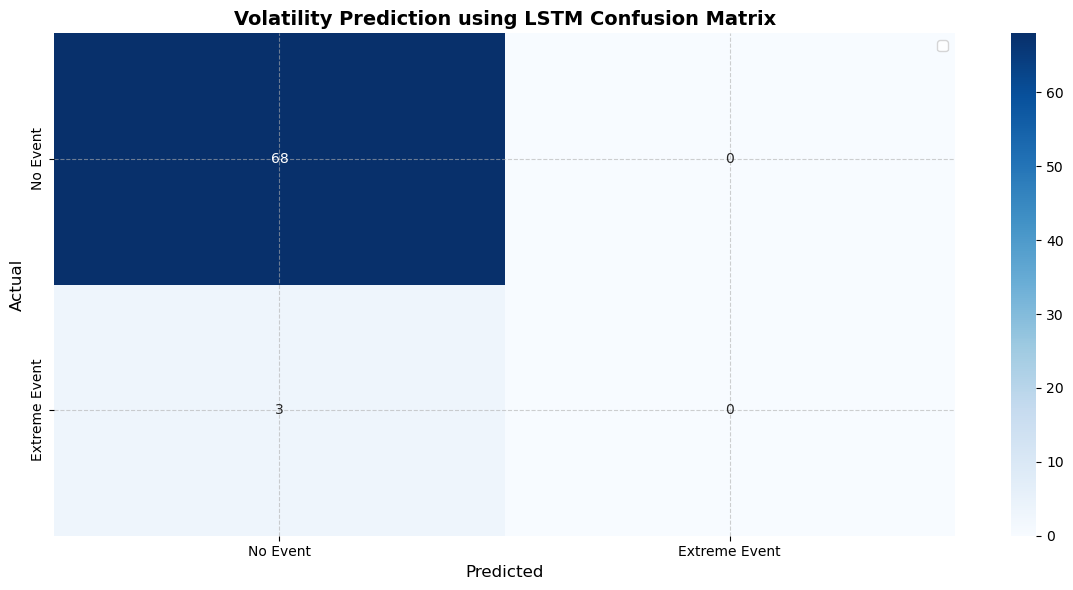

In [46]:
# Confusion matrix visualization
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=["No Event", "Extreme Event"], yticklabels=["No Event", "Extreme Event"])
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Volatility Prediction using LSTM Confusion Matrix", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)  # Add a subtle grid
plt.tight_layout() #avoid labels being cutoff
plt.savefig("Plots/Volatility Prediction using LSTM Confusion Matrix.png", dpi=200)
plt.show()

In [47]:
# Select relevant features
features = [
    "Net_Producer_Pos", "Net_Swap_Dealer_Pos", "Net_Money_Manager_Pos", "Net_Other_Reportable_Pos",
    "Price_Change", "SMA_10", "SMA_50", "Turning_Point",
    "Anomaly_Zscore", "Anomaly_IsolationForest"
]

In [48]:
df_selected = df[features]

In [49]:
# Normalize data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_selected), columns=features)

In [50]:
print("df_scaled Shape: ", df_scaled.shape)

df_scaled Shape:  (362, 10)


In [51]:
# Define Autoencoder architecture
input_dim = df_scaled.shape[1]
encoding_dim = 4  # Latent representation size

In [52]:
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)

In [53]:
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

In [54]:
# Compile Autoencoder model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [55]:
# Train model
autoencoder.fit(df_scaled, df_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0978 - val_loss: 0.1073
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0946 - val_loss: 0.1058
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0931 - val_loss: 0.1048
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0917 - val_loss: 0.1040
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0908 - val_loss: 0.1032
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0892 - val_loss: 0.1023
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0865 - val_loss: 0.1014
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0877 - val_loss: 0.1005
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0864 - val_loss: 0.0996
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0863 - val_loss: 0.0987
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0850 - val_loss: 0.0973
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.08

In [56]:
# Compute reconstruction error
df_scaled["Reconstruction_Error"] = np.mean((df_scaled - autoencoder.predict(df_scaled))**2, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [57]:
# Set threshold for anomalies (e.g., 95th percentile)
threshold = df_scaled["Reconstruction_Error"].quantile(0.95)
df_scaled["Anomalous_Trader"] = df_scaled["Reconstruction_Error"] > threshold

In [58]:
# Train One-Class SVM
ocsvm = OneClassSVM(nu=0.05, kernel="rbf")  # nu=0.05 allows 5% anomalies
df_scaled["OCSVM_Label"] = ocsvm.fit_predict(df_scaled.drop(columns=["Reconstruction_Error", "Anomalous_Trader"]))

In [59]:
# Convert labels: -1 = Anomaly, 1 = Normal
df_scaled["OCSVM_Anomalous_Trader"] = df_scaled["OCSVM_Label"] == -1

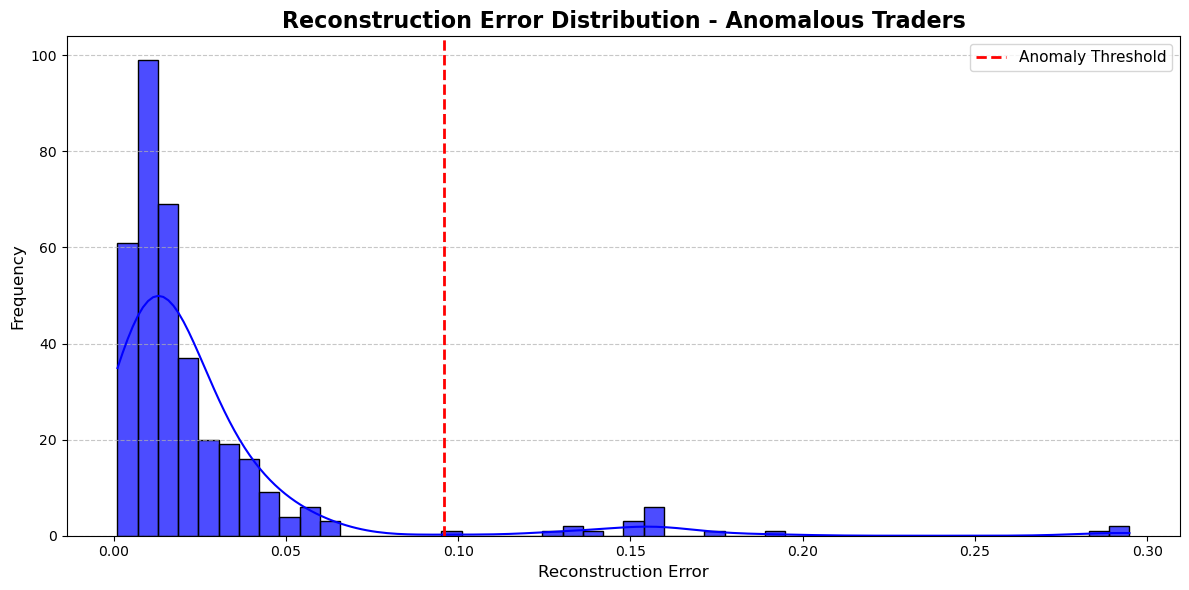

In [60]:
plt.figure(figsize=(12, 6))  # Increased figure size for better visibility

sns.histplot(
    df_scaled["Reconstruction_Error"],
    bins=50,
    kde=True,
    color="blue",  # Choose a more visually appealing color
    edgecolor="black", # add edgecolor
    alpha=0.7, #add slight transparency
)

plt.axvline(
    threshold,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Anomaly Threshold",
)

plt.legend(fontsize=11)  # Adjust legend font size
plt.title("Reconstruction Error Distribution - Anomalous Traders", fontsize=16, fontweight='bold')
plt.xlabel("Reconstruction Error", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Add gridlines for y-axis
plt.tight_layout() #avoid labels being cutoff
plt.savefig("Plots/Reconstruction Error Distribution - Anomalous Traders.png", dpi=200)
plt.show()

In [65]:
columns = []
for column in df_scaled.columns:
    columns.append({"Column": column, "Type": str(df_scaled[column].dtypes)})
columns_df = pd.DataFrame(columns)
columns_df

,Column,Type
0,Net_Producer_Pos,float64
1,Net_Swap_Dealer_Pos,float64
2,Net_Money_Manager_Pos,float64
3,Net_Other_Reportable_Pos,float64
4,Price_Change,float64
5,SMA_10,float64
6,SMA_50,float64
7,Turning_Point,float64
8,Anomaly_Zscore,float64
9,Anomaly_IsolationForest,float64


In [1]:
#df_scaled.to_csv(r"commodity-futures-trading-market-risk-exposure.csv")

In [68]:
columns_df.to_csv("Data/commodity-futures-trading-market-risk-exposure-scaled-df-columns.csv")